### Interpolate a time-series of ALOS-2 PALSAR-2 images to daily resolution
- uses linear interpolation for non-rainfed regions
- uses the pixel-wise correlation slopes for rainfed regions (with p-value<0.05) together with the net water daily data

**Inputs**
- ALOS-2 PALSAR-2 time series
- net water daily data
- pixel-wise correlation slopes/gradient output masked for peatland areas and p<0.05 (output from Peatland_PW_correlations.ipynb)

**Outputs**
- daily HH (+extend to other parameters)
- daily net water
- error map

In [1]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Declare data and output directories here



env: HDF5_USE_FILE_LOCKING=FALSE


### Summary of the interpolation algorithm (basic version)

$HH_{n}=HH_{0}+\frac{\sum\limits_{d=0}^{n-1}{NW_{daily}}}{m}$

where: 
 - $HH_{n}$ is the daily HH backscatter value to be calculated
 - m is the gradient of the linear regression between transect water depths and HH backscatter = 10.54
 - $NW_{daily}$ is the daily net water input
 
A more complex algorithm was previously used to derive the $HH_{n}$ values, but this led to some unreasonably large values due to the use of the ratio: $\frac{\delta{HH}}{\sum\limits_{d=0}^{n-1}{NW_{daily}}}$ not accounting well for the distribution of positive and negative net water contributions 
- see Flood_mapping_c2.ipynb for the corresponding functions for the previously used algorithms.

#### Considerations
- $\sum\limits_{d=0}^{n-1}\delta{HH_{daily}}$ should equal $\Delta{HH}$, (where $\Delta{HH}=HH_{n}-HH_{0}$) 
- a correction may be required if this is not the case

#### Alternative method
- the above described method is implemented in the function: interpolate_to_daily. Another version that was used is implemented in the function: interpolate_to_daily2. This also uses the above formula, but works forward to half-way to the next image, and backwards to half-way from the next image. The central images should ideally have the same value if the interpolation is correct.

#### Latest method
- there were still jumps in the interpolated values, using both the above methods. To compensate for this, the new method calculates forward and backwards interpolations from the previous and next images respectively, using the above described method, and applies a weighted average based on the proximity to the original image time. --> 2 interpolations are output from the interpolation method, and the weightings are applied after, to test different methods. Both linear and logistic decay/growth weighting methods were applied, and the logistic one showed better accuracy.

### Functions

In [3]:
def convert_to_WL(da,m,c):
    # uses the transect water depth linear regression values
    da2 = da*m + c
    
    # add extra bit to change the name of the variable to something more intuitive
    return (da2)

In [6]:
## Final version - gives choice of using prescribed gradient of linear 
## regression (option of grid==False) or pixel-wise gradients (option of grid==True)
## Additionally, the daily interpolation uses the nearest image, rather than the previous one

def interpolate_to_daily(da1, da2, all_dates, grid, extra_days, m, filename_f, filename_b):
    # inputs: HH masked for p<0.05 and corresponding NW daily.
    # outputs xarray of the interpolated daily HH values. 
    # e.g. usage: HH_daily, all_dates2 = interpolate_to_daily(HH_masked_peat_hc,nw_daily_100m,all_dates[13:],'True', 10,gradients_peat,'HH_daily_new.nc')
    # if grid = 'True', m is the gradient of the pixel wise linear regression between net water and HH backscatter
    # if grid = 'False', m is the gradient derived from the linear regression between water logger/ water table depths
    # and the HH backscatter
    
    # initialising arrays for the HH values associated with each start and end date pair
    HH_start = []
    HH_end = []
    
    # initialising the final HH daily forward and backwards interpolation arrays
    HH_daily_f = []
    HH_daily_b = []

    # looping over the images, up to the second last one in the image list
    for i in range(len(da1)-1):
        
        # start and end dates of each set of subsequent images
        HH_start.append(da1[i])
        HH_end.append(da1[i+1])
          
        start_date = all_dates[i]
        end_date = all_dates[i+1]
        print ('i: '+ str(i))
        
        total_days = (end_date-start_date).days
        print ("total days: " + str(total_days))
        
        # if the end_date is the last one in the series, then add the extra days to it:
        if i == (len(da1) - 2):
            print ("last image")
            end_date_final = all_dates[-1:] + timedelta(days=extra_days)
            print (end_date,end_date_final)
            total_days_final = total_days + extra_days
            print ("total days for the final image: " + str(total_days_final))
         
        print ("i, start date, end date")
        print (i, start_date,end_date)
               
        # 2. calculating the HH daily values by interpolating from the closest image
        for j in range(total_days): 
            
            current_date = start_date + pd.to_timedelta(j,unit='D')
 
            # calculating and appending the HH daily value
            # CASE 1. appending the actual original image values, where they match the current date in the daily time series
            
            if j==0:
                # The first HH_daily values for each set of subsequent images is substituted with the actual image
                HH_daily_f.append(HH_start[i].to_dataset(name='db'))
                HH_daily_b.append(HH_start[i].to_dataset(name='db'))
                #print ('j: ' + str(j) + ' - 1st image')
             
            # if it is the last loop in the series,then substitute the actual image data for this HH_daily value
            elif ((i==len(da1)-2) and (j==total_days-1)):
                HH_daily_f.append(HH_end[i].to_dataset(name='db'))
                HH_daily_b.append(HH_end[i].to_dataset(name='db'))
                #print ('j: ' + str(j) + ' - The last image in the original sequence')
             
            # append the last image in the current set of two images
            elif ((i!=len(da1)-2) and (j==total_days-1)):
                HH_daily_f.append(HH_end[i].to_dataset(name='db'))
                HH_daily_b.append(HH_end[i].to_dataset(name='db'))
                #print ('j: ' + str(j) + ' - The last image in the current image pair sequence')
            
            # CASE 2. Interpolate using the net water pattern for all other dates 

            #elif j < round(total_days/2):
            elif j < total_days:
                # a. the forward interpolation
                # calculating the sum of net water values between the start date and the day before current
                nw_sum_f = da2.sel(time=slice(start_date,current_date-timedelta(days=1))).sum(dim=('time'))

                # interpolating from the nearest, prior image
                new_f = HH_start[i] + nw_sum_f['net water']/m

                if grid == 'True':
                    HH_daily_f.append(new_f['gradient'].to_dataset(name='db'))
                else:
                    HH_daily_f.append(new_f.to_dataset(name='db'))

                #print ('j: ' + str(j) + ' - calculated from prior image')
                
                # b. the backwards interpolation
                # calculating the sum of net water values between the current date and the day before the end date
                nw_sum_b = da2.sel(time=slice(current_date,end_date-timedelta(days=1))).sum(dim=('time'))

                # interpolating from the end image
                new_b = HH_end[i] - nw_sum_b['net water']/m

                if grid == 'True':
                    HH_daily_b.append(new_b['gradient'].to_dataset(name='db'))
                else:
                    HH_daily_b.append(new_b.to_dataset(name='db'))                    

                #print ('j: ' + str(j) + ' - calculated from next image')                                
                                
        print ("i: " + str(i) + ' - interpolation complete for this image set.')

        # appending the additional daily interpolated images for the final image in the sequence 
        
        if ((j==total_days-1) and (i == (len(da1) - 2))):
            print ("Now forecasting the HH backscatter for the extra days...")
            print (j, total_days_final) 
            for k in range(j+1,total_days_final):
                current_date = end_date + pd.to_timedelta(k,unit='D') 
                # calculating the sum of net water values between the start date and the day before current
                nw_sum = da2.sel(time=slice(end_date,current_date-timedelta(days=1))).sum(dim=('time'))
                
                if grid == 'True':
                    HH_daily_f.append(new_f['gradient'].to_dataset(name='db'))
                else:
                    HH_daily_f.append(new_f.to_dataset(name='db'))

                print ('k: ' + str(k) + ' - calculated from prior image')
                         
    # creating a daily dates array to concatenate the HH daily with
    start_date = all_dates[0]
    image_last = len(da1) - 1
    end_date = all_dates[image_last] + timedelta(days=extra_days-1)
    
    # date range for the backwards interpolation
    end_date2 = all_dates[image_last]-timedelta(days=1)
    all_dates_b = pd.date_range(start_date,end_date2)
    
    # date range for the forwards interpolation
    all_dates_f = pd.date_range(start_date,end_date,freq='d')
    
    print ('concatenating the final arrays along the time dimension...')
    HH_daily_f = xr.concat(HH_daily_f,dim='time').assign_coords(time=all_dates_f)
    HH_daily_b = xr.concat(HH_daily_b,dim='time').assign_coords(time=all_dates_b)
    
    print ("Saving ALOS daily HH to netcdf...")
    HH_daily_f.to_netcdf(ALOS_OUT + filename_f)
    HH_daily_b.to_netcdf(ALOS_OUT + filename_b)
    
    print ('Proccessing completed.')   
    
    return (HH_daily_f, HH_daily_b, all_dates_f, all_dates_b)


In [7]:
def plot_correlations(df, pvalue_threshold, corr_threshold):
    # e.g. usage: plot_correlations(df,0.05,0.7)
    sns.set(font_scale=1.4,rc={'axes.facecolor':'white'}, style='ticks')
    df2 = df.drop(df[df['correlation']<corr_threshold].index)
    df2['gradient']=df2['gradient']
    df2 = df2.drop(df2[df2['pvalue']>pvalue_threshold].index)
    df2.dropna(inplace=True)

    var1 = df2['correlation']
    var2 = df2['gradient']
    var3 = df2['pvalue']

    print ('no. of values: ' +str(len(df2['pvalue'].unique())))
    
    print('standard dev of slopes: ' + str(df2['gradient'].std()))
    print('mean slope: ' + str(df2['gradient'].mean()))
    print('median slope: ' + str(df2['gradient'].median()))

    # binning the pvalues into 10 quantiles
    pvalue_min = df2['pvalue'].min()
    pvalue_max = df2['pvalue'].max()

    # Creating a list of 10 bins, covering the range of the pvalue column
    bins = [pvalue_min + (pvalue_max - pvalue_min) * i/10 for i in range(11)]
    labels = ['{:.2f}-{:.2f}'.format(bins[i], bins[i+1]) for i in range(10)]
    df2['pvalue_bins'] = pd.cut(df2['pvalue'], bins, labels=labels)

    # COLOUR brewer colours - suitable for colour blind

    # it would be good to make a similar plot comparing the MERIT Hydro slope/elevation etc. 
    colors = [ "#56B4E9", "#E69F00", "#808080", "#009E73", "#F0E442", "#0072B2", "#D55E00","#56B4E9","#F0E442","#CC79A7" ]

    #g = sns.scatterplot(data=df2, x='correlation', y='gradient', hue='pvalue_bins', palette=colors)
    #plt.legend(title='P-value range',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return (df2)

### Inputs

In [8]:
# land type map
lt_map = xr.open_dataset(ALOS_OUT + '/landtype_100m.nc')

# PW Correlation outputs
pw_pvals = xr.open_dataset(ALOS_OUT + 'pvals_da_HH_new.nc')
test = pw_pvals.to_array().to_dataset(name='pvalue')
pw_pvals = test['pvalue'][0][0].to_dataset(name='pvalue')
pw_pvals = pw_pvals.where(lt_map['type'].isin([4,5]))
pw_pvals = pw_pvals.drop('variable')

# open the alos-2 and daily net water regridded files (output from peatland_PW_correlation.ipynb)
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_masked.nc')

# the original HH data masked only for permanent water bodies and non-peat
HH_db_100m_all = xr.open_dataset(ALOS_OUT + 'HH_db_100m_masked_l.nc')

# The original unmasked version
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')

# masking for p>0.15
HH_db_100m_all = HH_db_100m_all.where(pw_pvals['pvalue']<=0.15)

nw_daily_100m = xr.open_dataset(ALOS_OUT + 'nw_daily_new_100m.nc')

# the gradients file (from PW correlations output, masked to include only peat pixels and p<0.05)
#gradients_peat = xr.open_dataset(ALOS_OUT + 'gradients_peat.nc')

# the original gradients dataset
gradients_peat = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
test = gradients_peat.to_array().to_dataset(name='gradient')
gradients_peat_all = test['gradient'][0][0].to_dataset(name='gradient')

corrs_peat2 = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
test = corrs_peat2.to_array().to_dataset(name='correlation')
corrs_peat_all = test['correlation'][0][0].to_dataset(name='correlation')

pvals_peat2 = xr.open_dataset(ALOS_OUT + 'pvals_da_HH_new.nc')
test = pvals_peat2.to_array().to_dataset(name='pvalue')
pvals_peat_all = test['pvalue'][0][0].to_dataset(name='pvalue')

### Main code

In [9]:
# Defining datetime series for the current set of ALOS-2 images

# array of alos2 scene dates within area 2 (the main area for which we have data)
all_dates = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09','2021-10-08','2021-11-19']

# converting to the datetime format required for dataframes
all_dates = pd.to_datetime(all_dates)
print ('Original radar image dates:\n', all_dates,'\n')


Original radar image dates:
 DatetimeIndex(['2019-03-29', '2019-05-10', '2019-06-21', '2019-07-19',
               '2019-08-30', '2019-10-11', '2019-11-22', '2020-01-03',
               '2020-02-14', '2020-03-27', '2020-05-08', '2020-06-19',
               '2020-07-17', '2020-08-28', '2020-10-09', '2021-10-08',
               '2021-11-19'],
              dtype='datetime64[ns]', freq=None) 



In [ ]:
%%time
# calculating the forward and backwards interpolations - this is the final version to be used
# This version calculates the rainfed interpolations for all peat pixels, rather than just ones where the
# pixel wise correlation pvalues < 0.05
# The outputs from p<0.05 analysis have 'rainfed' in the name instead of 'all'

HH_daily_f, HH_daily_b, all_dates_f, all_dates_b = \
interpolate_to_daily(HH_db_100m_all['db'][:15], nw_daily_100m, all_dates[:15],'True', 55, \
                      gradients_peat_all,'HH_daily_m_grid_all_f.nc','HH_daily_m_grid_all_b.nc')


### Applying logistic weights, backwards and forwards

In [10]:
# reading in the outputs from interpolate_to_daily3 function [this function is run below]
HH_daily_f = xr.open_dataset(ALOS_OUT + 'HH_daily_m_grid_all_f.nc')
HH_daily_b = xr.open_dataset(ALOS_OUT + 'HH_daily_m_grid_all_b.nc')

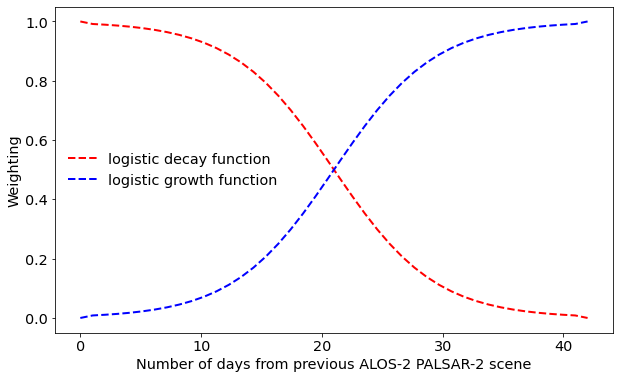

logistic decay weights
[1.         0.99147421 0.98914479 0.98618777 0.98243956 0.9776972
 0.971711   0.96417694 0.95472985 0.94293886 0.92830741 0.9102812
 0.88826804 0.86167454 0.82996311 0.7927305  0.74980283 0.70133404
 0.64788516 0.5904567  0.53045008 0.46954992 0.4095433  0.35211484
 0.29866596 0.25019717 0.2072695  0.17003689 0.13832546 0.11173196
 0.0897188  0.07169259 0.05706114 0.04527015 0.03582306 0.028289
 0.0223028  0.01756044 0.01381223 0.01085521 0.00852579 0.        ]
logistic growth weights
[0.         0.00852579 0.01085521 0.01381223 0.01756044 0.0223028
 0.028289   0.03582306 0.04527015 0.05706114 0.07169259 0.0897188
 0.11173196 0.13832546 0.17003689 0.2072695  0.25019717 0.29866596
 0.35211484 0.4095433  0.46954992 0.53045008 0.5904567  0.64788516
 0.70133404 0.74980283 0.7927305  0.82996311 0.86167454 0.88826804
 0.9102812  0.92830741 0.94293886 0.95472985 0.96417694 0.971711
 0.9776972  0.98243956 0.98618777 0.98914479 0.99147421 1.        ]
42


In [12]:
# Testing the application of logistic sigmoid function

def log_values(x,sign):
    # -0.5 used to centre it at 0.5 instead of the origin
    return 1 / (1 + np.exp(sign * 10 * (x - 0.5)))

total_days = 42
x = np.linspace(0, 1, total_days)


# logistic decay function 
y1 = [log_values(i, 1) for i in x]
y1 = np.clip(y1, 0, 1)

# assigning the first and last values to be 0 and 1 respectively, so that the actual HH image at t=0 is used without weighting
y1[0] = 1
y1[-1:] = 0

plt.figure(figsize=(10,6))
plt.plot(x*total_days, y1, "r--", linewidth = 2, label = 'logistic decay function')

# logistic growth function
y2 = [log_values(i, -1) for i in x]
y2 = np.clip(y2, 0, 1)

# assigning the first and last values to be 1 and 0 respectively, so that the actual HH image at t=0 is used without weighting
y2[0] = 0
y2[-1:] = 1

plt.plot(x*total_days, y2, "b--", linewidth=2, label = 'logistic growth function')

plt.legend(loc = 'center left', frameon=False)
plt.xlabel('Number of days from previous ALOS-2 PALSAR-2 scene')
plt.ylabel('Weighting')
plt.show()

print ('logistic decay weights')
print (y1)

print ('logistic growth weights')
print (y2)

print (len(y1))

In [ ]:
# logistic decay function
weights_decay = [log_values(i, 1) for i in x]
weights_decay = np.clip(weights_decay, 0, 1)

# assigning the first and last values to be 1 and 0 respectively, so that the actual HH image at t=0 is used without weighting
weights_decay[0] = 1
weights_decay[-1:] = 0

print (weights_decay)

# logistic growth function
weights_growth = [log_values(i, -1) for i in x]
weights_growth = np.clip(weights_growth, 0, 1)

# assigning the first and last values to be 0 and 1 respectively, so that the actual HH image at t=0 is used without weighting
weights_decay[0] = 0
weights_decay[-1:] = 1
    
    

In [ ]:
%%time
# forward and backwards interpolation - applying the weights - logistic decay/growth version 

def log_values(x,sign):
  return 1 / (1 + np.exp(sign * 10 * (x - 0.5)))

ds = []

# now applying the forward and backwards weightings to the interpolated forward daily HH 
counter = 0
for i in range(len(all_dates[:15])):
    # 1. finding the difference between subsequent dates
    start_date = all_dates[i]
    end_date = all_dates[i+1]
    total_days = (end_date-start_date).days
    
    # 2. creating the forward and backwards weighting arrays
    x = np.linspace(0, 1, total_days)

    
    # logistic decay function
    weights_decay = [log_values(i, 1) for i in x]
    weights_decay = np.clip(weights_decay, 0, 1)
    
    # assigning the first and last values to be 1 and 0 respectively, so that the actual HH image at t=0 is used without weighting
    weights_decay[0] = 1
    weights_decay[-1:] = 0

    # logistic growth function
    weights_growth = [log_values(i, -1) for i in x]
    weights_growth = np.clip(weights_growth, 0, 1)
    
    # assigning the first and last values to be 0 and 1 respectively, so that the actual HH image at t=0 is used without weighting
    weights_growth[0] = 0
    weights_growth[-1:] = 1
    
    # 3. looping through the number of days between each pair of image start and end dates
    for j in range(total_days):
        if counter < len(HH_daily_b['db']):
            current_date = start_date + timedelta(days=j)
            print ('counter: ' + str(counter) + ', i: ' + str(i) + ', j: ' + str(j) + ', current date: ' + str(current_date))
            print ('weight_F: ' + str(weights_decay[j]) + ', and weight_B:' + str(weights_growth[j]) + '\n')
            ds.append((weights_decay[j] * HH_daily_f['db'][counter]) + (weights_growth[j] * HH_daily_b['db'][counter]))

        counter = counter + 1

# 4. concatenating the data arrays
print ('concatenating the ds array...')
ds_final = xr.concat(ds, dim='time')
ds_final = ds_final.to_dataset(name='db')

# 5. removing anomalous pixels (testing smoothing algorithm instead - see Smooth_HH_daily_anomalies.ipynb)
#print ('removing anomalous pixels...')
#ds_final = ds_final.where((ds_final.db>-11) & (ds_final.db<=0))  

# 6. saving the final interpolated data to netcdf
print ('saving to netcdf...')
ds_final.to_netcdf(ALOS_OUT + 'HH_daily_mgrid_all_weighted_logistic.nc')

    